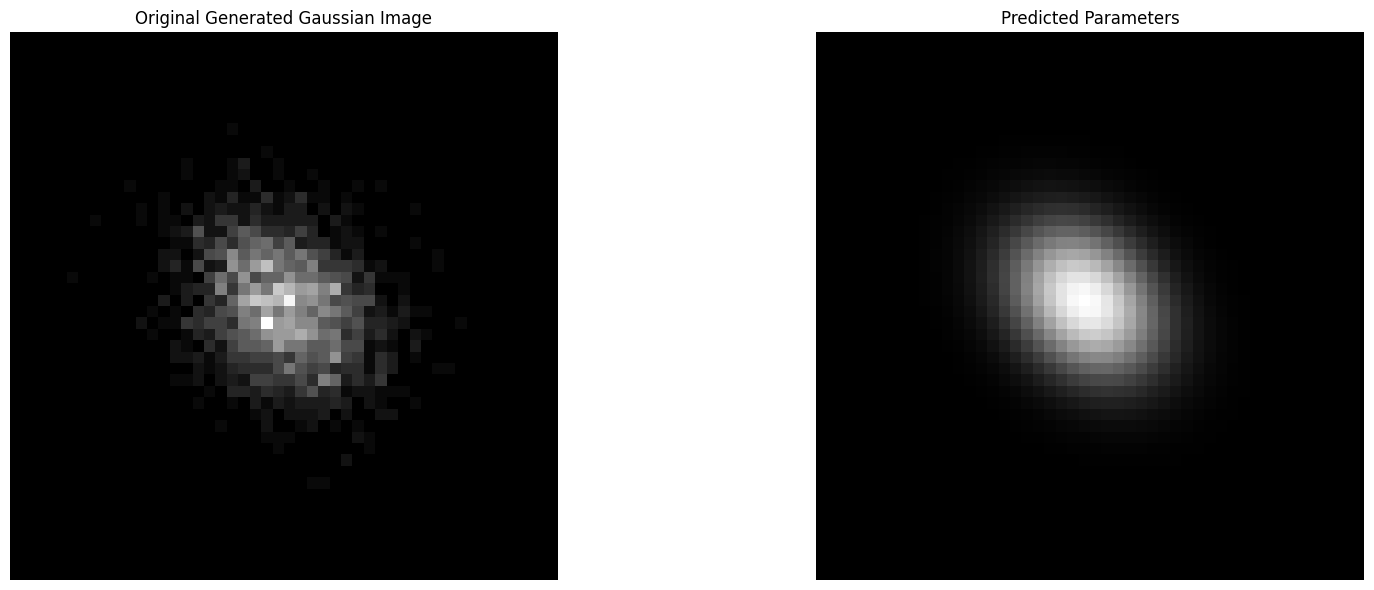

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter
import os

def generate_gaussian_image(size, mean, cov):
    num_pixels = size[0] * size[1]
    x = np.random.multivariate_normal(mean, cov, num_pixels)
    x = np.clip(x, 0, size[0] - 1).astype(int)
    image = np.zeros(size, dtype=np.float32)
    for i in range(num_pixels):
        image[x[i, 1], x[i, 0]] += 1
    return image

def generate_ideal_gaussian_image(size, mean, cov):
    x, y = np.meshgrid(np.arange(size[0]), np.arange(size[1]))
    xy = np.column_stack([x.ravel(), y.ravel()])
    
    inv_cov = np.linalg.inv(cov)
    diff = xy - mean
    z = np.exp(-0.5 * np.sum(diff @ inv_cov * diff, axis=1))
    z = z.reshape(size)
    z /= z.max() 
    
    return z

def estimate_gaussian_parameters(data, weights):
    sigma = 1.0
    smoothed_data = gaussian_filter(data, sigma=sigma)

    mean = np.average(smoothed_data, axis=0, weights=weights)
    
    diff = data - mean
    covariance_matrix = np.cov(diff.T, aweights=weights, bias=True)
    
    return mean, covariance_matrix, smoothed_data

def plot_covariance_ellipse(mean, cov, ax, color='blue', label=None):
    eigenvalues, eigenvectors = np.linalg.eigh(cov)
    order = eigenvalues.argsort()[::-1]
    eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
    
    # Compute the angle of the ellipse
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))
    
    # Compute the width and height of the ellipse
    width, height = 2 * np.sqrt(eigenvalues)
    
    # Create and add the ellipse patch
    ellipse = Ellipse(xy=mean, width=width, height=height, angle=angle, color=color, alpha=0.5)
    ax.add_patch(ellipse)
    
    if label:
        ax.legend([ellipse], [label])
    
    return mean, cov, angle

size = (48, 48)
mean = np.array([24, 24]) 
cov = np.array([[20, 5], [5, 20]]) 

image = generate_gaussian_image(size, mean, cov)

y_coords, x_coords = np.indices(size)
data = np.vstack((x_coords.ravel(), y_coords.ravel())).T
weights = image.ravel()

estimated_mean, estimated_covariance_matrix, smoothed_data = estimate_gaussian_parameters(data, weights)
ideal_image = generate_ideal_gaussian_image(size, estimated_mean, estimated_covariance_matrix)

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray', origin='upper')
plt.title('Original Generated Gaussian Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ideal_image, cmap='gray', origin='upper')
plt.title('Predicted Parameters')
plt.axis('off')

plt.tight_layout()
plt.show()

mean_x, cov_x, angle_x = plot_covariance_ellipse(mean, cov, plt.gca(), color='red', label='Original Gaussian')
cov_x_x, cov_x_y = cov[0, 0], cov[0, 1]
cov_y_y = cov[1, 1]

print("Original Gaussian Parameters:")
print("Mean:", mean_x)
print("Covariance Matrix:")
print(cov)
print("Covariance x-x:", cov_x_x)
print("Covariance x-y:", cov_x_y)
print("Covariance y-y:", cov_y_y)
print("Angle (degrees):", angle_x)

mean_y, cov_y, angle_y = plot_covariance_ellipse(estimated_mean, estimated_covariance_matrix, plt.gca(), color='blue', label='Estimated Gaussian')
cov_y_x, cov_y_y = estimated_covariance_matrix[0, 0], estimated_covariance_matrix[0, 1]
cov_y_y = estimated_covariance_matrix[1, 1]

print("\nEstimated Gaussian Parameters:")
print("Mean:", mean_y)
print("Covariance Matrix:")
print(cov_y)
print("Covariance x-x:", cov_y_x)
print("Covariance x-y:", cov_y_y)
print("Covariance y-y:", cov_y_y)
print("Angle (degrees):", angle_y)
